In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from datetime import datetime, timedelta
%matplotlib inline

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

In [2]:
pd.set_option('display.max_rows', 100) # выведем больше строк
pd.set_option('display.max_columns', 100) # выведем больше колонок

In [3]:
# Фиксируем RANDOM_SEED, чтобы результаты были воспроизводимы
RANDOM_SEED = 42

In [4]:
date_today = pd.to_datetime('2020-07-15')

In [5]:
df = pd.read_csv('main_task.csv')

In [6]:
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'reviews_number', 'reviews', 'url_ta', 'id_ta']
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   restaurant_id   40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine_style   30717 non-null  object 
 3   ranking         40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price_range     26114 non-null  object 
 6   reviews_number  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url_ta          40000 non-null  object 
 9   id_ta           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df.describe()

,ranking,rating,reviews_number
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


In [9]:
df.nunique()

restaurant_id     11909
city                 31
cuisine_style      9007
ranking           11936
rating                9
price_range           3
reviews_number     1459
reviews           33516
url_ta            39980
id_ta             39980
dtype: int64

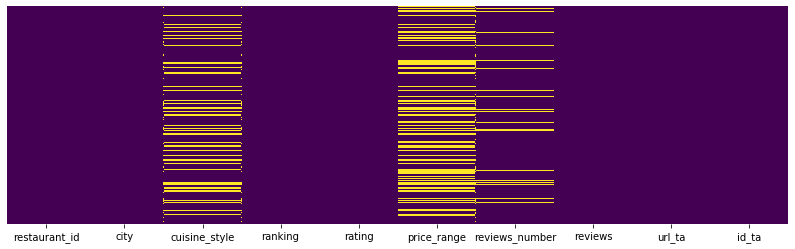

In [10]:
#Анализ пропусков в столбцах
plt.figure(figsize=(14, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap = 'viridis')

## Осмотр и обработка данных и генерация новых признаков 

In [11]:
def analyse_numeric(datafr, column):
    '''Визуализирует распределение числовой переменной.
       Принимает параметрами DataFrame и строковое название столбца
       Печатает различные статистические показатели и строит гистограмму.'''
    count = datafr[column].count()
    mean = datafr[column].mean()
    std = datafr[column].std()
    median = datafr[column].median()
    perc25 = datafr[column].quantile(0.25)
    perc75 = datafr[column].quantile(0.75)
    IQR = perc75 - perc25
    range_min = datafr[column].min()
    range_max = datafr[column].max()
    margin = (range_max - range_min)/10
    range_start = range_min - margin
    range_stop = range_max + margin
    range_ = (range_start, range_stop)
    outliers = datafr[column].loc[(datafr[column] < perc25 - 1.5*IQR) | (datafr[column] > perc75 + 1.5*IQR)]

    print('Количество: {}, Среднее: {:.3f}, Стандартное отклонение: {:.3f}.'.format(count, mean, std))
    print('Минимум: {}, 25-й перцентиль: {}, Медиана: {}, 75-й перцентиль: {}, Максимум: {}, IQR: {}.'
          .format(range_min, perc25, median, perc75, range_max, IQR))
    print('Количество пропусков в столбце: ', pd.isnull(datafr[column]).sum())
    print('Границы выбросов: [{f}, {l}].'.format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR)
          , 'Количество выбросов: ', len(outliers))

    datafr[column].loc[datafr[column].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)] \
                  .hist(bins = 30, range = range_, label = 'В границах выбросов')
    outliers.hist(bins = 30, range = range_, label = 'Выбросы')
    
    plt.legend()

### restaurant_id

In [12]:
df.restaurant_id.nunique()

11909

### city

In [13]:
df_tmp = df.city.value_counts()
df_tmp

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: city, dtype: int64

#### Добавим столбец количества ресторанов в городе

In [14]:
df['rests'] = df['city'].apply(lambda x: df_tmp[x])

#### Поработаем с популяциями городов. Добавим столбец population двумя разными способми: из внешнего датасета worldcities.csv с https://kaggle.com и из Википедии, https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits и проверим, какой способ лучше.

#### Способ 1

In [15]:
#cities = pd.read_csv('.\data\worldcities.csv')
#cities.head()

In [16]:
def get_population(str_city):
    '''Возвращает популяцию города str_city'''
    if str_city.lower() == 'oporto': # Такого названия нет в датасете cities
        str_city = 'porto'
    return cities[cities.city_ascii.str.lower() == str_city.lower()]['population'].max()

In [17]:
#df['population'] = df.city.apply(lambda x: get_population(x))

#### Способ 2

In [18]:
population_dict = {
    'London': 9304016,
    'Paris': 2140526,
    'Madrid': 3348536,
    'Barcelona': 1620343,
    'Berlin': 3748148,
    'Milan': 1404239,
    'Rome': 2856133,
    'Prague': 1324277,
    'Lisbon': 506654,
    'Vienna': 1911728,
    'Amsterdam': 873555,
    'Brussels': 1209000,
    'Hamburg': 1841179,
    'Munich': 1471508,
    'Lyon': 515695,
    'Stockholm': 974073,
    'Budapest': 1752286,
    'Warsaw': 1790658,
    'Dublin': 554554,
    'Copenhagen': 626508,
    'Athens': 664046,
    'Edinburgh': 524930,
    'Zurich': 415367,
    'Oporto': 237559,
    'Geneva': 201818,
    'Krakow': 779115,
    'Oslo': 693491,
    'Helsinki': 648042,
    'Bratislava': 432864,
    'Luxembourg': 613894,
    'Ljubljana': 292988
}
df['population'] = df['city'].map(population_dict)

#### Пронормируем столбец population (получим значения в тысячах жителей)

In [19]:
df['population'] = df['population'] / 1000

#### Добавим столбец плотности ресторанов в городе

In [20]:
df['rest_density'] = df.rests / df.population

#### Добавим признак capital

In [21]:
capitals = ['Paris', 'Stockholm', 'London', 'Berlin',
            'Bratislava', 'Vienna', 'Rome', 'Madrid',
            'Dublin', 'Brussels', 'Warsaw', 'Budapest', 'Copenhagen',
            'Amsterdam', 'Lisbon', 'Prague', 'Oslo',
            'Helsinki', 'Ljubljana', 'Athens', 'Luxembourg']
#df['capital'] = df['city'].apply(lambda x: x in capitals).astype('uint8')

#### Добавим признак country

In [22]:
countries_dict = {'Amsterdam': 'Netherlands',
             'Athens': 'Greece',
             'Barcelona': 'Spain',
             'Berlin': 'Germany',
             'Bratislava': 'Slovakia',
             'Brussels': 'Belgium',
             'Budapest': 'Hungary',
             'Copenhagen': 'Denmark',
             'Dublin': 'Ireland',
             'Edinburgh': 'UK',
             'Geneva': 'Switzerland',
             'Hamburg': 'Germany',
             'Helsinki': 'Finland',
             'Krakow': 'Poland',
             'Lisbon': 'Portugal',
             'Ljubljana': 'Slovenia',
             'London': 'UK',
             'Luxembourg': 'Luxembourg',
             'Lyon': 'France',
             'Madrid': 'Spain',
             'Milan': 'Italy',
             'Munich': 'Germany',
             'Oporto': 'Portugal',
             'Oslo': 'Norway',
             'Paris': 'France',
             'Prague': 'Czechia',
             'Rome': 'Italy',
             'Stockholm': 'Sweden',
             'Vienna': 'Austria',
             'Warsaw': 'Poland',
             'Zurich': 'Switzerland'}

df['country'] = df['city'].map(countries_dict)
#df.country = df.country.apply(lambda s: s + '_')

#### Добавим dummies по странам

In [23]:
#df = pd.concat([df, pd.get_dummies(df.country)], axis=1)
df = pd.get_dummies(df, columns=['country']) # , dummy_na=True # в странах пропусков нет
df.head(3)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,4897,2140.526,2.287755,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,820,974.073,0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,5757,9304.016,0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Добавим dummies по городам

In [24]:
# Альтернативный вариант кода: df = pd.concat([df, pd.get_dummies(df.city)], axis=1) - Не добавляет префикс city
df = pd.get_dummies(df, columns=['city',]) # , dummy_na=True # в городах пропусков нет
df.head(3)

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich
0,id_5569,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,4897,2140.526,2.287755,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,id_1535,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,820,974.073,0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,id_352,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,5757,9304.016,0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### cuisine_style

In [25]:
df.cuisine_style.value_counts()

['Italian']                                                                                                        1032
['French']                                                                                                          805
['Spanish']                                                                                                         695
['French', 'European']                                                                                              405
['Cafe']                                                                                                            403
                                                                                                                   ... 
['Eastern European', 'Romanian', 'European', 'Vegetarian Friendly']                                                   1
['Bar', 'Mediterranean', 'European', 'Contemporary', 'Pub', 'Portuguese']                                             1
['Cafe', 'Fast Food', 'Soups', 'Vegetari

In [26]:
df['cuisine_style_isna'] = pd.isna(df.cuisine_style).astype('uint8')

In [27]:
df.cuisine_style.fillna('1', inplace=True)

In [28]:
df['cuisine'] = df.cuisine_style.str[1:-1].str.split(', ')

In [29]:
df['cuisine'].head()

0              ['European', 'French', 'International']
1                                                   []
2    ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                   []
4    ['German', 'Central European', 'Vegetarian Fri...
Name: cuisine, dtype: object

In [30]:
len(df.explode('cuisine')['cuisine'].value_counts())

126

In [31]:
# Создадим новый признак - количество кухонь, представленных рестораном
df['cuisines_number'] = df['cuisine'].apply( lambda x: 1.0 if len(x)==0 else float(len(x)))

### ranking

Количество: 40000, Среднее: 3676.029, Стандартное отклонение: 3708.750.
Минимум: 1.0, 25-й перцентиль: 973.0, Медиана: 2285.0, 75-й перцентиль: 5260.0, Максимум: 16444.0, IQR: 4287.0.
Количество пропусков в столбце:  0
Границы выбросов: [-5457.5, 11690.5]. Количество выбросов:  2450


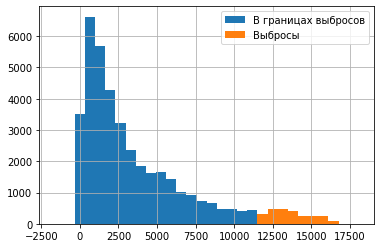

In [32]:
analyse_numeric(df, 'ranking')

In [33]:
# Удалим грубые выбросы
#df=df[df.ranking < 13000]

In [34]:
# Создадим новый признак путем нормирования ranking к количеству ресторанов в городе
df['ranking_norm_rests'] = df.ranking / df.rests

### rating

Количество: 40000, Среднее: 3.993, Стандартное отклонение: 0.668.
Минимум: 1.0, 25-й перцентиль: 3.5, Медиана: 4.0, 75-й перцентиль: 4.5, Максимум: 5.0, IQR: 1.0.
Количество пропусков в столбце:  0
Границы выбросов: [2.0, 6.0]. Количество выбросов:  340


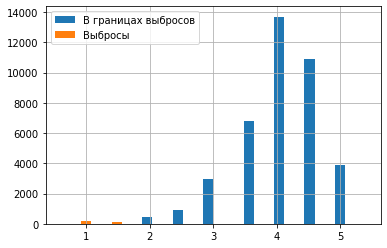

In [35]:
analyse_numeric(df, 'rating')

### price_range

In [36]:
df.price_range.value_counts(dropna=False)

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [37]:
df['price_range_isna'] = pd.isna(df.price_range).astype('uint8')

In [38]:
# Либо так:
#df['price_range_label'] = df.price_range.apply(lambda x: 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0 if x=='$$$$' else np.nan)
# и заполним медианой по городам
#df.price_range_label = df.apply(lambda row: df[df.city==row.city].price_range_label.median() if pd.isna(row.price_range_label) \
#                                                                                     else row.price_range_label, axis=1)

# Либо так:
df['price_range_label'] = df.price_range.apply(lambda x: 2.5 if pd.isnull(x) else 1.0 if x=='$' else 2.5 if x=='$$ - $$$' else 4.0)

### reviews_number

Количество: 37457, Среднее: 124.825, Стандартное отклонение: 295.666.
Минимум: 2.0, 25-й перцентиль: 9.0, Медиана: 33.0, 75-й перцентиль: 115.0, Максимум: 9660.0, IQR: 106.0.
Количество пропусков в столбце:  2543
Границы выбросов: [-150.0, 274.0]. Количество выбросов:  4348


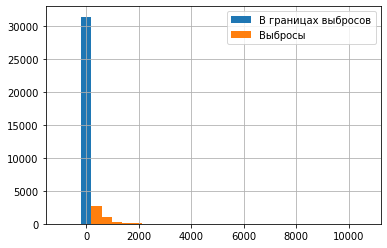

In [39]:
analyse_numeric(df, 'reviews_number')

In [40]:
df['reviews_number_isna'] = pd.isna(df.reviews_number).astype('uint8')

In [41]:
len(df[df.reviews_number > 2000])

140

In [42]:
#Удалим грубые выбросы
#df=df[df.reviews_number < 2000]

In [43]:
#!!! Нужно пробовать одно из двух!!!
# Замена пропусков медианой по соответствующему городу
#df.reviews_number = df.apply(lambda row: df[df.city==row.city].reviews_number.median() if pd.isna(row.reviews_number) \
#                                                                                     else row.reviews_number, axis=1)

# Замена пропусков нулевым значением
df.reviews_number.fillna(0, inplace=True)

In [44]:
# Нормируем количество отзывов к населению города
df['reviews_number_norm'] = df.reviews_number / df.population

### reviews

In [45]:
#pd.DataFrame(df.reviews.value_counts())
df.reviews.value_counts()

[[], []]                                                                                                6471
[['Great food, service and atmosphere', 'Decor and food'], ['11/06/2017', '10/22/2017']]                   2
[['The real codido madrileño'], ['03/31/2017']]                                                            2
[['Simply Excellent!', 'Modern!'], ['10/22/2017', '08/29/2017']]                                           2
[['Sat night', 'Can\'t even explain.. "A" place.. A "100...'], ['10/22/2017', '05/11/2017']]               2
                                                                                                        ... 
[['Good bar', 'Great little bar'], ['11/19/2017', '11/06/2017']]                                           1
[['Restaurant at the rear', 'Civilized, Classic Madrid'], ['03/21/2017', '09/06/2017']]                    1
[['Best traditional cooking ever!', 'the real taste'], ['12/19/2017', '10/10/2017']]                       1
[['Unadulterated Vi

In [46]:
df['reviews_dates'] = df['reviews'].str.findall('\d+/\d+/\d+')
df[['reviews', 'reviews_dates']].head()

,reviews,reviews_dates
0,"[['Good food at your doorstep', 'A good hotel ...","[12/31/2017, 11/20/2017]"
1,"[['Unique cuisine', 'Delicious Nepalese food']...","[07/06/2017, 06/19/2016]"
2,"[['Catch up with friends', 'Not exceptional'],...","[01/08/2018, 01/06/2018]"
3,"[[], []]",[]
4,"[['Best place to try a Bavarian food', 'Nice b...","[11/18/2017, 02/19/2017]"


In [47]:
df['review1_date'] = df.reviews_dates.apply(lambda x: x[0] if len(x)>0 else None)
df['review1_date']

0        12/31/2017
1        07/06/2017
2        01/08/2018
3              None
4        11/18/2017
            ...    
39995    12/16/2017
39996    12/21/2017
39997    11/03/2016
39998    07/11/2017
39999    01/31/2016
Name: review1_date, Length: 40000, dtype: object

In [48]:
#На этом значении в следующей ячейке возникает ошибка
df[df['review1_date']=='29/9/2016']

,restaurant_id,cuisine_style,ranking,rating,price_range,reviews_number,reviews,url_ta,id_ta,rests,population,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,city_Prague,city_Rome,city_Stockholm,city_Vienna,city_Warsaw,city_Zurich,cuisine_style_isna,cuisine,cuisines_number,ranking_norm_rests,price_range_isna,price_range_label,reviews_number_isna,reviews_number_norm,reviews_dates,review1_date
23348,id_450,"['French', 'European']",453.0,4.0,$$ - $$$,48.0,"[['lunch 29/9/2016', 'Unplanned Great Dinner']...",/Restaurant_Review-g188057-d2706773-Reviews-Le...,d2706773,481,201.818,2.383335,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['French', 'European']",2.0,0.941788,0,2.5,0,0.237838,"[29/9/2016, 09/30/2016, 08/25/2016]",29/9/2016


In [49]:
#df[df['review1_date']=='29/9/2016'].review1_date = '09/29/2016'
df.loc[23348, 'review1_date'] = '09/29/2016'

In [50]:
df['review1_date_d'] = df.review1_date.apply(lambda x: None if pd.isna(x) else datetime.strptime(x, '%m/%d/%Y'))

In [51]:
df['review2_date'] = df.reviews_dates.apply(lambda x: x[1] if len(x)>1 else None)

In [52]:
df['review2_date_d'] = df.reviews_dates.apply(lambda x: datetime.strptime(x[1], '%m/%d/%Y') if len(x)>1 else None)

In [53]:
df['review1_date_d'].max()

Timestamp('2018-02-26 00:00:00')

In [54]:
df['review2_date_d'].max()

Timestamp('2018-02-26 00:00:00')

In [55]:
(df.review1_date_d - df.review2_date_d).dt.days.max()

3207.0

In [56]:
# Создадим новый признак - количество дней между отзывами
df['days_between'] = ((df.review1_date_d - df.review2_date_d).dt.days)#abs

Количество: 28973, Среднее: 124.079, Стандартное отклонение: 231.519.
Минимум: -362.0, 25-й перцентиль: 13.0, Медиана: 55.0, 75-й перцентиль: 156.0, Максимум: 3207.0, IQR: 143.0.
Количество пропусков в столбце:  11027
Границы выбросов: [-201.5, 370.5]. Количество выбросов:  3070


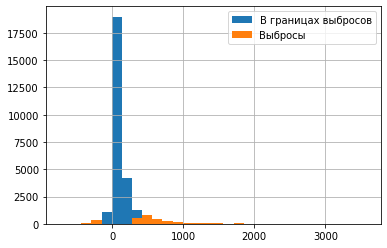

In [57]:
analyse_numeric(df, 'days_between')

In [58]:
len(df[df.days_between > 1000])

382

In [59]:
#df[df.days_between > 2000]

In [60]:
len(df[df.days_between < 0])

1948

In [61]:
# Удалим грубые выбросы
#df=df[df.days_between <= 2000]

In [62]:
# !!! Пока заполним пропуски медианой
df.days_between.fillna(df.days_between.median(), inplace=True)

In [63]:
# Создадим новый признак - количество дней между последним отзывом и сегодняшней датой 
df['days_to_today'] = ((date_today - df.review1_date_d).dt.days)#abs

Количество: 33529, Среднее: 1166.984, Стандартное отклонение: 362.442.
Минимум: 870.0, 25-й перцентиль: 952.0, Медиана: 1037.0, 75-й перцентиль: 1225.0, Максимум: 5929.0, IQR: 273.0.
Количество пропусков в столбце:  6471
Границы выбросов: [542.5, 1634.5]. Количество выбросов:  2892


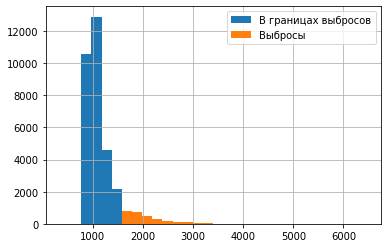

In [64]:
analyse_numeric(df, 'days_to_today')

In [65]:
df.days_to_today.fillna(df.days_to_today.median(), inplace=True)

In [66]:
# # Создадим новый признак - день недели последнего отзыва
# df['last_review_weekday'] = df.review1_date_d.dt.weekday

In [67]:
# analyse_numeric(df, 'last_review_weekday')

In [68]:
# most_frequent_weekday = df['last_review_weekday'].value_counts().sort_values(ascending=False).iloc[0]

In [69]:
# df.last_review_weekday.fillna(most_frequent_weekday, inplace=True)
# df.last_review_weekday.isna().sum()

### url_ta

In [70]:
df.url_ta.value_counts()

/Restaurant_Review-g187514-d10047799-Reviews-Entrepuntos-Madrid.html                                                    2
/Restaurant_Review-g187514-d13002276-Reviews-Delish_Vegan_Doughnuts-Madrid.html                                         2
/Restaurant_Review-g187514-d3161682-Reviews-Cerveceria_La_Surena-Madrid.html                                            2
/Restaurant_Review-g187514-d793170-Reviews-Caripen_Bistro-Madrid.html                                                   2
/Restaurant_Review-g187514-d9877640-Reviews-Raku_Sushi-Madrid.html                                                      2
                                                                                                                       ..
/Restaurant_Review-g187514-d10353450-Reviews-Hemingway_s_Bar-Madrid.html                                                1
/Restaurant_Review-g187514-d8855203-Reviews-Mercado_de_Los_Mostenses_Bar_Chino-Madrid.html                              1
/Restaurant_Review-g1891

### id_ta

In [71]:
df.id_ta.value_counts()

d9877640     2
d13002276    2
d4600226     2
d11999956    2
d793170      2
            ..
d5961438     1
d5081096     1
d10627619    1
d4698842     1
d6420527     1
Name: id_ta, Length: 39980, dtype: int64

In [72]:
# Преобразуем id_ta в числа (будет новый признак):
df['id_ta_num'] = df['id_ta'].str[1:].astype('int64')#'float64'

## Попробуем текстовую классификацию

In [73]:
import string
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [74]:
pd.options.mode.chained_assignment = None

In [75]:
def stop_words_remover(text):
    text = text.lower() 
    
    singles = [word for word in text.split()]
    text = ' '.join(singles)
        
    #Удаление незначимых слов
    stw = ['a', 'at', 'on', 'of', 'and', 'or', 'in', 'for', 'at', 'empty', 'cuisine', 'food' ]
    stw.extend(['restaura', 'restauran', 'restaurant', 'restaurante', 'restaurants', 'resto', 'restuarant',
                'restau', 'restaur', 'resturant'])
    
    stw.extend(list(x.lower() for x in countries_dict.keys()))
    stw.extend(list(x.lower() for x in countries_dict.values()))
    
    remove = r'\b(' + '|'.join(stw) + r')\b'  
    text = re.sub(remove, ' ', text)
    
    return  text

In [76]:
english_stemmer = SnowballStemmer("english")
class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        #return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))
        return lambda doc: (w for w in analyzer(doc))

vect_tfidf = StemmedTfidfVectorizer(min_df=10
                                    ,max_df=0.7
                                    ,stop_words='english'
                                    ,ngram_range=(1, 1)
                                    #,decode_error='ignore'
                                    ,strip_accents='ascii' #'unicode', 'ascii', None
                                    #,preprocessor=stop_words_remover
                                   )
print(vect_tfidf)

StemmedTfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                       dtype=<class 'numpy.float64'>, encoding='utf-8',
                       input='content', lowercase=True, max_df=0.7,
                       max_features=None, min_df=10, ngram_range=(1, 1),
                       norm='l2', preprocessor=None, smooth_idf=True,
                       stop_words='english', strip_accents='ascii',
                       sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                       tokenizer=None, use_idf=True, vocabulary=None)


In [77]:
# Удаляем цифры
df.reviews = df.reviews.apply(lambda s: re.sub(r'\b\d+\b', '', s))

In [78]:
df.reviews = df.reviews.apply(lambda s: stop_words_remover(s))

In [79]:
X_tfidf = vect_tfidf.fit_transform(df.reviews)

In [80]:
num_samples_tfidf, num_features_tfidf = X_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(len(vect_tfidf.get_feature_names()))
print(vect_tfidf.get_feature_names())

#samples: 40000, #features: 1334
1334
['1st', '2nd', 'absolute', 'absolutely', 'acceptable', 'accident', 'accommodating', 'acropolis', 'addition', 'address', 'adequate', 'adorable', 'affordable', 'african', 'afternoon', 'air', 'airport', 'al', 'alcohol', 'ale', 'alright', 'alternative', 'amazing', 'amazingly', 'ambiance', 'ambience', 'ambient', 'american', 'anymore', 'aperitivo', 'appalling', 'apple', 'area', 'argentinian', 'arrogant', 'art', 'asian', 'ask', 'ate', 'athmosphere', 'atmo', 'atmos', 'atmosp', 'atmosph', 'atmosphe', 'atmospher', 'atmosphere', 'atmospheric', 'attention', 'attentive', 'attitude', 'austrian', 'authentic', 'available', 'average', 'avoid', 'away', 'awesome', 'awful', 'bad', 'bagels', 'baguette', 'baked', 'bakery', 'bar', 'bargain', 'bartender', 'basement', 'basic', 'bavarian', 'bbq', 'bcn', 'beach', 'beat', 'beaten', 'beautiful', 'beautifully', 'beef', 'beer', 'beers', 'belgian', 'believe', 'best', 'bet', 'better', 'beware', 'bien', 'biergarten', 'big', 'bigges

In [81]:
print(X_tfidf[0])
print(X_tfidf.toarray().shape)

  (0, 562)	0.7730280604742882
  (0, 496)	0.63437182922901
(40000, 1334)


In [82]:
df.reviews[0]

"[['good     your doorstep', '  good hotel  '], ['//', '//']]"

In [83]:
# print(vect_tfidf.get_feature_names()[2292])
# print(vect_tfidf.get_feature_names()[1362])
# print(vect_tfidf.get_feature_names()[835])
# print(vect_tfidf.get_feature_names()[1086])
# print(vect_tfidf.get_feature_names()[1212])

In [84]:
features_matrix = X_tfidf.toarray()

#### Добавляем признаки на основе слов в отзывах со значением частоты встречаемости слова в конкретном отзыве

In [85]:
for i in range(features_matrix.shape[1]):
    feat_to_add = str(i) + '_f'
    df[feat_to_add] = features_matrix[:,i]

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [86]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['restaurant_id', 'rating', 'cuisine_style', 'price_range', 'url_ta', 'id_ta', #, 'reviews'
             'cuisine', 'reviews_dates', 'review1_date', 'review2_date', 'review1_date_d',
             'review2_date_d', 'rests', 'population', 'reviews'], axis = 1)
y = df['rating']

X.head(3)

,ranking,reviews_number,rest_density,country_Austria,country_Belgium,country_Czechia,country_Denmark,country_Finland,country_France,country_Germany,country_Greece,country_Hungary,country_Ireland,country_Italy,country_Luxembourg,country_Netherlands,country_Norway,country_Poland,country_Portugal,country_Slovakia,country_Slovenia,country_Spain,country_Sweden,country_Switzerland,country_UK,city_Amsterdam,city_Athens,city_Barcelona,city_Berlin,city_Bratislava,city_Brussels,city_Budapest,city_Copenhagen,city_Dublin,city_Edinburgh,city_Geneva,city_Hamburg,city_Helsinki,city_Krakow,city_Lisbon,city_Ljubljana,city_London,city_Luxembourg,city_Lyon,city_Madrid,city_Milan,city_Munich,city_Oporto,city_Oslo,city_Paris,...,1284_f,1285_f,1286_f,1287_f,1288_f,1289_f,1290_f,1291_f,1292_f,1293_f,1294_f,1295_f,1296_f,1297_f,1298_f,1299_f,1300_f,1301_f,1302_f,1303_f,1304_f,1305_f,1306_f,1307_f,1308_f,1309_f,1310_f,1311_f,1312_f,1313_f,1314_f,1315_f,1316_f,1317_f,1318_f,1319_f,1320_f,1321_f,1322_f,1323_f,1324_f,1325_f,1326_f,1327_f,1328_f,1329_f,1330_f,1331_f,1332_f,1333_f
0,5570.0,194.0,2.287755,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1537.0,10.0,0.841826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,353.0,688.0,0.618765,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

## Создание, обучение и тестирование модели

In [88]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = (regr.predict(X_test)*2).round()/2

In [89]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.16265


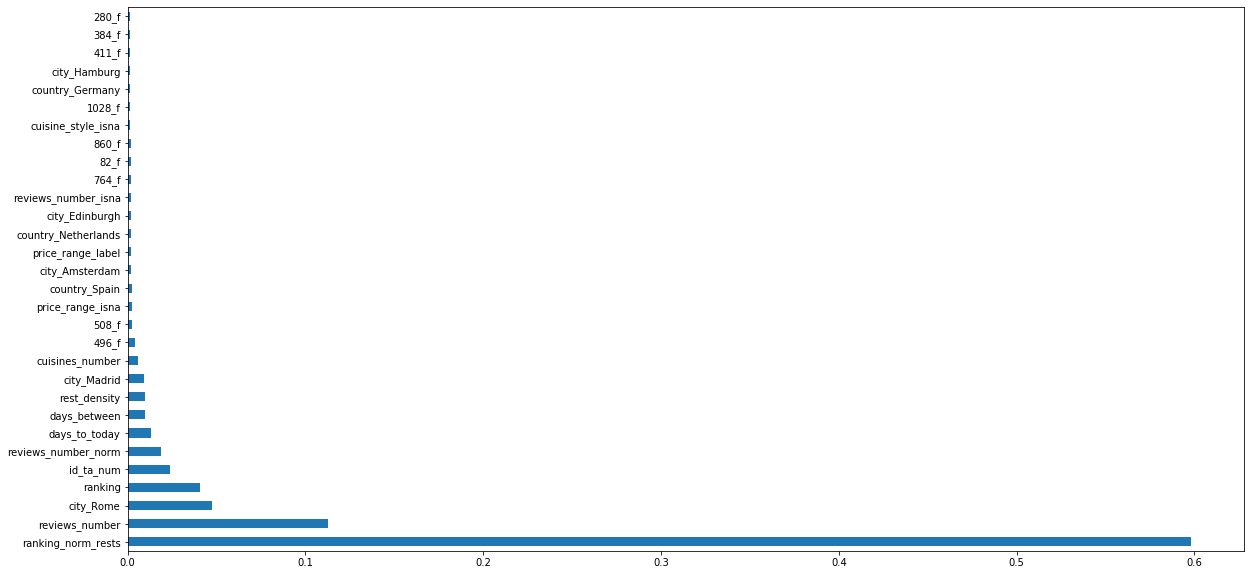

In [90]:
# Отображаем признаки, отсортированные по их значимости
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [91]:
from ipython_exit import exit

In [92]:
# составляем список важнейших признаков
main_features = feat_importances.nlargest(500).index.tolist()

In [93]:
feat_importances.sort_values(ascending=False)[:100]

ranking_norm_rests     0.597876
reviews_number         0.112859
city_Rome              0.047363
ranking                0.040948
id_ta_num              0.023566
reviews_number_norm    0.018868
days_to_today          0.012963
days_between           0.009839
rest_density           0.009617
city_Madrid            0.008978
cuisines_number        0.005911
496_f                  0.003868
508_f                  0.002645
price_range_isna       0.002401
country_Spain          0.002192
city_Amsterdam         0.002007
price_range_label      0.001933
country_Netherlands    0.001885
city_Edinburgh         0.001792
reviews_number_isna    0.001702
764_f                  0.001693
82_f                   0.001630
860_f                  0.001587
cuisine_style_isna     0.001532
1028_f                 0.001361
country_Germany        0.001245
city_Hamburg           0.001214
411_f                  0.001196
384_f                  0.001190
280_f                  0.001128
22_f                   0.001012
city_Ber

In [94]:
exit()

IpyExit: 

In [ ]:
# Еще раз копируем датасет, оставив только важнейшие признаки:
X = X[main_features].copy()
X_train = X_train[main_features].copy()
X_test = X_test[main_features].copy()

In [ ]:
# X.head()

In [ ]:
# Пересоздаем модель, используя только самые важные признаки
regr = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)
regr.fit(X_train, y_train)
y_pred = (regr.predict(X_test)*2).round()/2
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# Отображаем признаки, отсортированные по их значимости
plt.rcParams['figure.figsize'] = (20, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')